# 3D Ising model exploration
Jan Petsch 3247767, Leonardo Cremona 3245833

## Introduction

##### The Ising model

The Ising model is a simplified model of ferromagnetic materials. The model has N atoms described by their spin defined by a binary variable equal to 1 or -1. Spins are located on a D-dimensional square grid. In this notebook we will consider the 3D version where spins are arranged on a cubic lattice.

Spins interact with their nearest neighbours, and the energy of a configuration
is described by the Hamiltonian

$$
E = -J \sum_{\langle i,j \rangle} s_i s_j,
$$

where:

- J is the strength of ferromagnetic interaction
- the sum runs over all pair (i,j) that are nearest neighbours 

---
##### Boltzmann distribution
At thermal equilibrium, the probability of observing a given spin configuration
\(S\) in the Ising model is given by the Boltzmann distribution

$$
P_B(S) = \frac{1}{Z} \exp\!\left( -\frac{E(S)}{T} \right),
$$

where

- \(E(S)\) is the energy of configuration \(S\),
- \(T\) is the temperature,
- \(Z\) is the **partition function**

$$
Z = \sum_{S} \exp\!\left( -\frac{E(S)}{T} \right),
$$

which ensures that all probabilities sum to 1.

This distribution favours configurations with lower energy (meaning aligned spins),
and suppresses configurations with misaligned neighbours.

---
##### Monte Carlo and Metropolis algorithm
Because the number of possible configurations grows exponentially with system size, direct enumeration becomes impossible.
Instead, we rely on **Markov Chain Monte Carlo** to generate representative
spin configurations according to the Boltzmann distribution:

$$
P(S) \propto e^{-E(S)/T}.
$$

The Metropolis algorithm, is used to propose local spin flips
and accept or reject them based on the energy change:

$$
p_{\text{acc}} = \min\!\left(1, \; e^{-(E_{\text{new}} - E_{\text{old}})/T}\right).
$$

This produces a sequence of configurations that, after equilibration, represent thermal samples
from the 3D Ising model at temperature \(T\).

---
#### Goals of the Project

The purpose of this notebook is to implement and explore the 3D Ising model using the Monte Carlo
methods. We will define the model, simulate its behaviour for different parameters, and analyse how key observables depend on these parameters. We will mainly study how the energy and magnetization will depend on the temperature, number of monte carlo steps or the total number of spins.

Our main research question is:

**How does the magnetization vary with temperature for different system sizes in the 3D Ising model?**

---
Note: for most of the graphs involving plotting the magnetization value we will use the absolute value of magnetization as we are mainly interested if the system will enter the ferromagnetic or paramagnetic stage.

Let's import the packages we will need

In [224]:
import numpy as np
import matplotlib.pyplot as plt
import random as rnd
import seaborn as sns
from math import exp
import re
import pandas as pd
import time

## Defining the functions needed for successful simulation

Let's define the energy calculation function for our 3D model. We will use nearest neighbours for each spin which involve neighbours in the x, y and z direction.

The Hamiltonian of the 3D Ising model with coupling constant $J$ is:

$$
E = -J \sum_{\langle i,j \rangle} s_i s_j,
$$

We sum only over the positive directions o avoid double-counting:

$$
E = -J \sum_{i,j,k}
\left(
s_{i,j,k}\,s_{i+1,j,k}
+ s_{i,j,k}\,s_{i,j+1,k}
+ s_{i,j,k}\,s_{i,j,k+1}
\right).
$$

We implement periodic boundary conditions using modulo indexing:

$$
(i+1) \rightarrow (i+1)\bmod L,\qquad
(j+1) \rightarrow (j+1)\bmod L,\qquad
(k+1) \rightarrow (k+1)\bmod L.
$$


In [34]:
def energy(state, J):
    L = state.shape[0]
    e = 0.0
    for i in range(L):
        for j in range(L):
            for k in range(L):
                s = state[i, j, k]
                e -= J * s * state[(i + 1) % L, j, k]
                e -= J * s * state[i, (j + 1) % L, k]
                e -= J * s * state[i, j, (k + 1) % L]
    return e

We will also implement a function calculating **local energy change**. This is due to the fact that recomputing the total energy of the entire system after every attempted spin flip is very costly when flipping a single spin only affects the six nearest-neighbour interactions.

$$
\Delta E = E_{\text{new}} - E_{\text{old}}
= 2 J s_{i,j,k} \sum_{\text{nearest neighbours}} s_{\text{nn}} .
$$

This turns each Metropolis step into an $\mathcal{O}(1)$ operation instead of $\mathcal{O}(L^3)$, dramatically improving performance.

In [35]:
def delta_energy(state, i, j, k, J):
    L = state.shape[0]
    s = state[i, j, k]
    nn = (
        state[(i+1) % L, j, k] +
        state[(i-1) % L, j, k] +
        state[i, (j+1) % L, k] +
        state[i, (j-1) % L, k] +
        state[i, j, (k+1) % L] +
        state[i, j, (k-1) % L]
    )
    return 2 * J * s * nn

Now, let's define the Metropolis acceptance function that will evaluate whether the flip of a spin should be accepted. We compare the
**old** energy $E_{\text{old}}$ with the **new** energy $E_{\text{new}}$ at
temperature $T$.

The Metropolis acceptance probability is

$$
p_{\text{acc}} =
\min\!\left(1,\;\exp\!\left[-\frac{E_{\text{new}} - E_{\text{old}}}{T}\right]\right).
$$

The rules are:

- If $E_{\text{new}} < E_{\text{old}}$ we **always** accept the move.
- If $E_{\text{new}} > E_{\text{old}}$, we accept the move with probability  $\exp\!\left[-(E_{\text{new}} - E_{\text{old}})/T\right]$.


In [36]:
def metropolis(e_old, e_new, T):
    if e_new < e_old:
        return True
    else:
        if np.random.random() < exp((e_old - e_new) / T):
            return True
        return False

Now let's define the **flip and magnetization functions**.

Each spin has either a +1 or -1 value. The **flip function** simply switches the sign of the spin value:

$$
s_{i,j,k} \;\longrightarrow\; -s_{i,j,k},
$$

The **magnetization per spin** is defined as the average of all spins in the
system:

$$
m = \frac{1}{N} \sum_{i,j,k} s_{i,j,k},
$$

In [37]:
def flip(state, i, j, k):
    state[i, j, k] = -state[i, j, k]

def magnetization(state):
    return np.sum(state) / state.size

## Simulation part

### Example simulation
First let's perform an example simulation to get the idea of how the model works for some standard parameters. Later on we will move to actual testing various combinations.

We first chose the following simulation parameters:

- **side** – linear size of the cubic lattice.  
  For example, side = 10 gives a lattice of (10^3 = 1000) spins.

- **T** – temperature

- **J** – coupling constant.  
  For \(J > 0\) the interaction is ferromagnetic (neighbouring spins prefer to align).

- **nstep** – number of Monte Carlo steps in the simulation.

- **seed** – random seed used to initialise the random number generator,  
  so that the simulation is reproducible.


In [38]:
side = 10
t = 2
J = 1.0  
nstep = 50000
seed = 67  

We begin the simulation by generating a random initial spin configuration for
the 3D lattice. To visualize this 3D configuration, we display the middle 2D slice of the lattice.

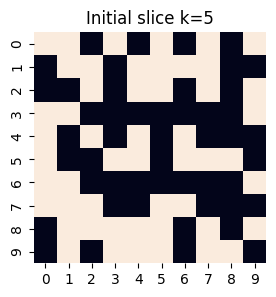

In [39]:
state = 2 * np.random.randint(2, size=(side, side, side)) - 1

plt.figure(figsize=(3, 3))
mid = side // 2
sns.heatmap(state[:, :, mid], vmin=-1, vmax=1, cbar=False)
plt.title(f"Initial slice k={mid}")
plt.show()

We now define the Metropolis Monte Carlo simulation function.  
Starting from the initial configuration, we repeatedly propose flipping a randomly chosen spin.

For each Monte Carlo step:

1. Select a random spin
2. Compute the local energy change
3. Accept the flip with probability
$$
p = \min\left(1, e^{-\Delta E / T}\right)
$$
4. If accepted, update the spin and update the total energy
$$
E \leftarrow E + \Delta E
$$
and the total magnetization
$$
M \leftarrow M - 2\, s_{i,j,k}
$$
5. Record the energy and magnetization per spin


In [40]:
def run_simulation_fast(state, side, t, J, nstep, seed):
    E = energy(state, J)
    M = np.sum(state)
    e_history = []
    m_history = []
    np.random.seed(seed)

    for istep in range(nstep):
        i = np.random.randint(side)
        j = np.random.randint(side)
        k = np.random.randint(side)
        dE = delta_energy(state, i, j, k, J)
        if dE < 0 or np.random.random() < np.exp(-dE / t):
            s_old = state[i, j, k]
            state[i, j, k] = -s_old
            E += dE
            M += -2 * s_old
        e_history.append(E / state.size)
        m_history.append(M / state.size)
    return e_history, m_history, state

Let's run an example simulation and plot the Energy and magnetization vs step to see the results.

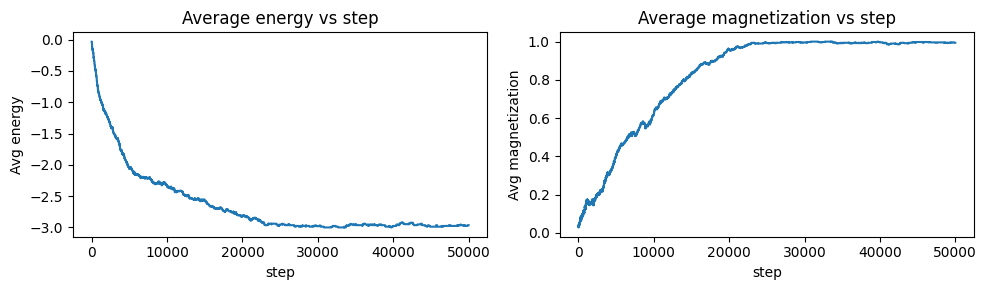

In [41]:
e_hist, m_hist, final_state = run_simulation_fast(
    state, side, t, J, nstep, seed
)

fig, axes = plt.subplots(1, 2, figsize=(10, 3))

axes[0].plot(e_hist)
axes[0].set_xlabel("step")
axes[0].set_ylabel("Avg energy")
axes[0].set_title("Average energy vs step")

axes[1].plot(m_hist)
axes[1].set_xlabel("step")
axes[1].set_ylabel("Avg magnetization")
axes[1].set_title("Average magnetization vs step")

plt.tight_layout()
plt.show()

From the two plots we observe that the system equilibrates after roughly 30,000
Monte Carlo steps. The average energy curve decreases rapidly at first as the
initially random configuration moves toward lower energy states and then
stabilizes, indicating that equilibrium has been reached.   

At the same time, the magnetization
decreases to -1, showing that the system has entered a ferromagnetic state (vast majority of spins are alligned). After equilibration, both quantities
fluctuate around steady values, consistent with sampling from the Boltzmann distribution.
This behaviour is expected at low temperature, since spin flips that increase the energy are almost always rejected by the Metropolis algorithm.

Let's now check the average energy and magnetization for all of the steps after removing the first half of them. Those can be considered the equilibrium values.

In [42]:
cut = int(nstep/2)
e_sel = e_hist[cut:]
m_sel = m_hist[cut:]

avE = np.mean(e_sel)
avM = np.mean(m_sel)

print("Average energy:", avE)
print("Average magnetization:", avM)


Average energy: -2.970342079999999
Average magnetization: 0.9949275200000001


### Parameters exploration

#### Energy and Magnetization vs temperature
We now move to exploring the different variations of parameters and relationships between different variables. Let's first explore how the average energy and magnetization changes with temperature value for an example L = 10. We set the J constant to 1 for easier analysis and number of steps to 100000 to analyse the whole process extensively.

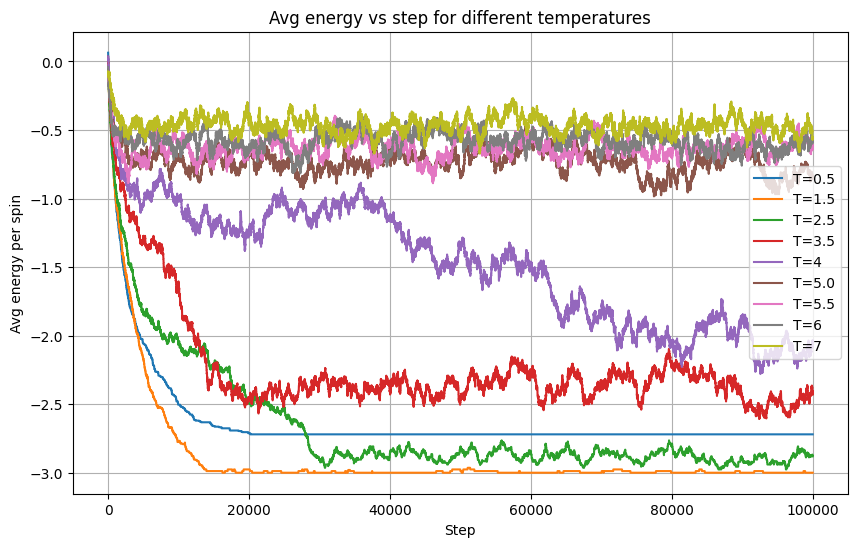

In [43]:
side = 10
J = 1.0
nstep = 100000
seed = 67
temps = [0.5, 1.5, 2.5, 3.5, 4 ,5.0, 5.5, 6, 7]

plt.figure(figsize=(10, 6))
final_states = {}

for t in temps:
    state = 2 * np.random.randint(2, size=(side, side, side)) - 1

    e_hist, m_hist, final_state = run_simulation_fast(
        state, side, t, J, nstep, seed
    )

    plt.plot(e_hist, label=f"T={t}")
    final_states[t] = final_state
    

plt.xlabel("Step")
plt.ylabel("Avg energy per spin")
plt.title("Avg energy vs step for different temperatures")
plt.legend()
plt.grid(True)
plt.show()


When the simulation begins, the system is at a random
configuration, which corresponds to a high energy, disordered state. As the Metropolis
algorithm progresses, the system moves toward equilibrium.

We can observe that for:

* **Lower temperatures**  
  The energy rapidly decreases and approaches lower values.  
  This reflects the formation of large ordered domains. The system moves toward
  a nearly fully aligned state.

* **High temperatures**  
  Initially the energy decreases, but still remains close to zero and fluctuates around a steady value. Here the thermal disorder dominates, the spins remain mostly uncorrelated,
  and the system does not develop long-range order.

Note: We consider low temperatures for T = 4 or less and high temperatures for T = 5 or more. We will explore the values from 4 to 5 in a second as those values are close to the critical temperature ~4.5.

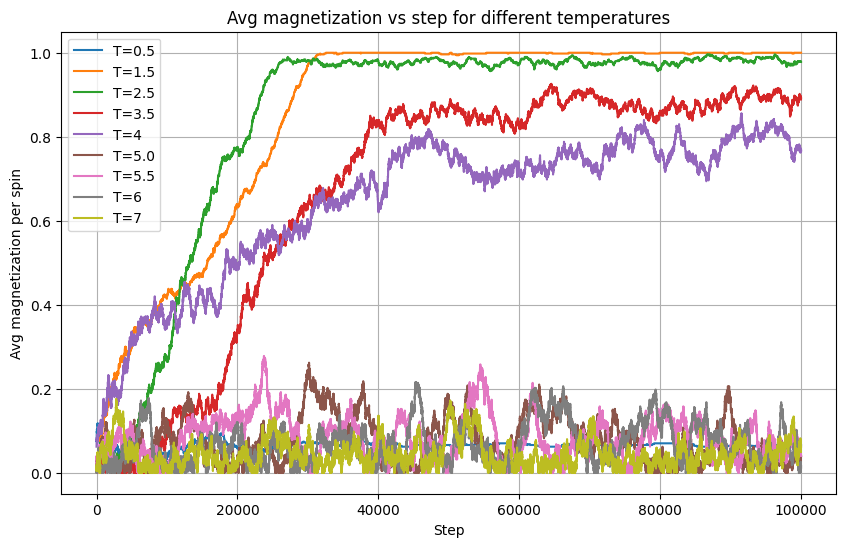

In [44]:
plt.figure(figsize=(10, 6))

for t in temps:
    state = 2 * np.random.randint(2, size=(side, side, side)) - 1

    e_hist, m_hist, final_state = run_simulation_fast(
        state, side, t, J, nstep, seed
    )
    plt.plot(np.abs(m_hist), label=f"T={t}")

plt.xlabel("Step")
plt.ylabel("Avg magnetization per spin")
plt.title("Avg magnetization vs step for different temperatures")
plt.legend()
plt.grid(True)
plt.show()


At the beginning the system is in a random configuration so the initial magnetization value for all temperatures is 0. We can observe that for:

**Lower temperatures:**  
Magnetization grows steadily toward large values.  
At low temperature, the system minimizes energy by aligning spins, forming a
large ordered domain.

**Higher temperatures:**  
Magnetization fluctuates close to zero for the entire simulation.  
At high temperature thermal noise dominates, spins remain mostly disordered,   
and
the system does not develop any global allignment. This corresponds to the
paramagnetic phase.

Let's plot and example 2D side from the cube after the simulation for low (2) and high (6) temperature to see that for the high temperature the side will have aligned spin and for the high temperature, not aligned spins.

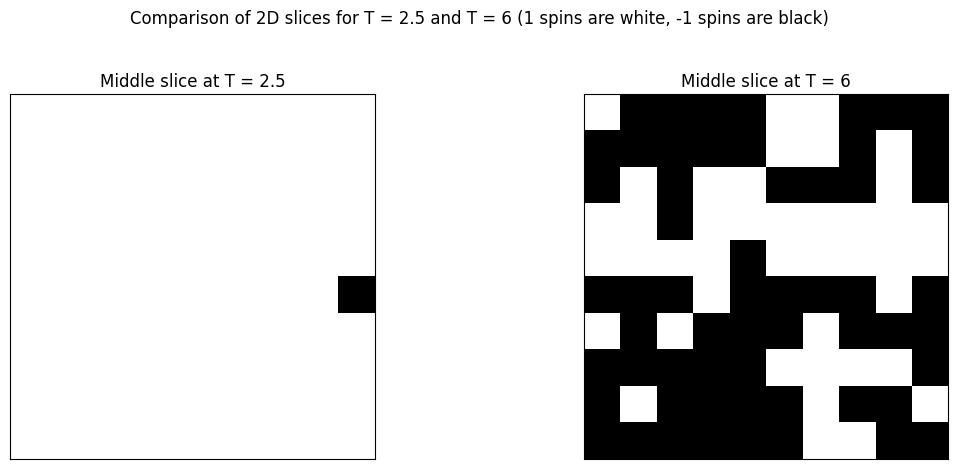

In [45]:
temps_to_show = [2.5, 6]
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

mid = side // 2

for ax, T in zip(axes, temps_to_show):
    slice2D = final_states[T][mid, :, :]
    im = ax.imshow(slice2D, cmap="gray", vmin=-1, vmax=1)
    ax.set_title(f"Middle slice at T = {T}")
    ax.set_xticks([])
    ax.set_yticks([])

plt.suptitle("Comparison of 2D slices for T = 2.5 and T = 6 (1 spins are white, -1 spins are black)")
plt.tight_layout(rect=[0, 0.05, 1, 0.95]) 
plt.show()


#### Magnetization behaviour near the critical temperature

The critical temperature/phase transition temperature for a 3D Ising system is known to be ~4.5.  
 Let's explore how the system will behave for temperatures close to that value. Let's continue the analysis with L = 10.

Text(0.5, 1.0, 'Magnetization vs step for critical-region temperatures')

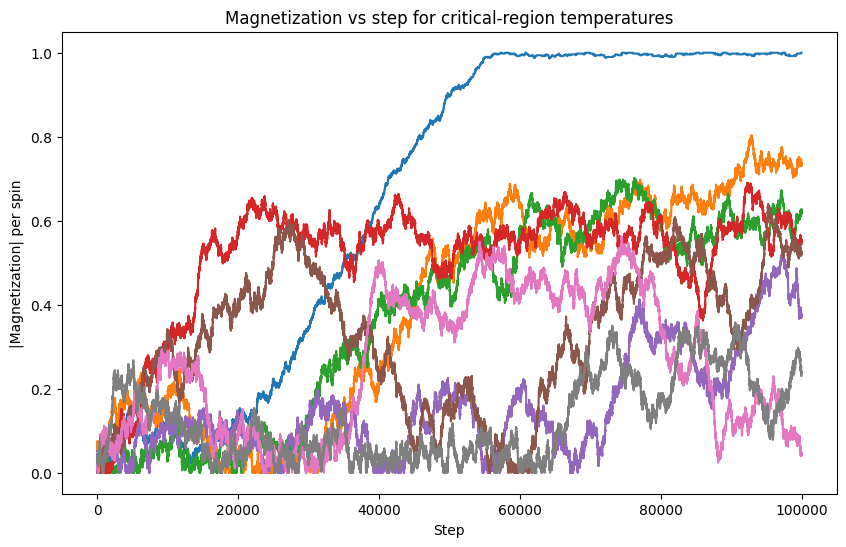

In [46]:
side = 10
J = 1.0
nstep = 100000
seed = 67
temps = [2,4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8]

plt.figure(figsize=(10, 6))

for t in temps:
    state = 2 * np.random.randint(2, size=(side, side, side)) - 1
    e_hist, m_hist, final_state = run_simulation_fast(state, side, t, J, nstep, seed)

    plt.plot(np.abs(m_hist), label=f"T={t}")

plt.xlabel("Step")
plt.ylabel("|Magnetization| per spin")
plt.title("Magnetization vs step for critical-region temperatures")


We included one curve with a temperature far from the critical one (T = 2) to strengthen the observation. The magnetization curves n the temperature range T ≈ 4.2–4.8 appear noisy and don't settle for a clear equilibrium value within the simulation time. This behaviour
is expected and can be explained by several physical effects:

**1. Critical slowing down**  
As the system approaches the phase transition, the rate at which domains grow
and reorganize becomes extremely slow. Thus, even after many Monte Carlo
steps the system has not developed a stable magnetization.

**2. Large fluctuations**  
Near the critical temperature, two competing effects fight:
the ferromagnetic coupling, which tries to align neighbouring spins into large
domains, and the thermal fluctuations, which try to randomise and break up
these domains. As a result, the magnetization exhibits large fluctuations: domains grow and collapse repeatedly,leading to strong variations in the measured magnetization.


**3. Trend relative to the critical point**  
Temperatures slightly below the critical value (T ≲ 4.5) tend to drift toward
larger magnetization values, whereas temperatures slightly above it
(T ≳ 4.5) tend to remain closer to zero. However, due to strong fluctuations,
the distinction is blurred compared to low or high temperatures.

#### Magnetization vs step for different values of N

Before moving on to our main research interest "Magnetization as a function of temperature, for different values of the number of spins N", let's check how will the magnetization value change plotted vs step for different sizes of the cube for a fixed temperature T = 1. This will help us to get more insights about how does the number of spins in our system influence other parameters.

/var/folders/cm/9hgr6tsn4nx0r2hqdh1_mt3h0000gn/T/ipykernel_81395/2782674831.py:20: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/Users/janekpetsch/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


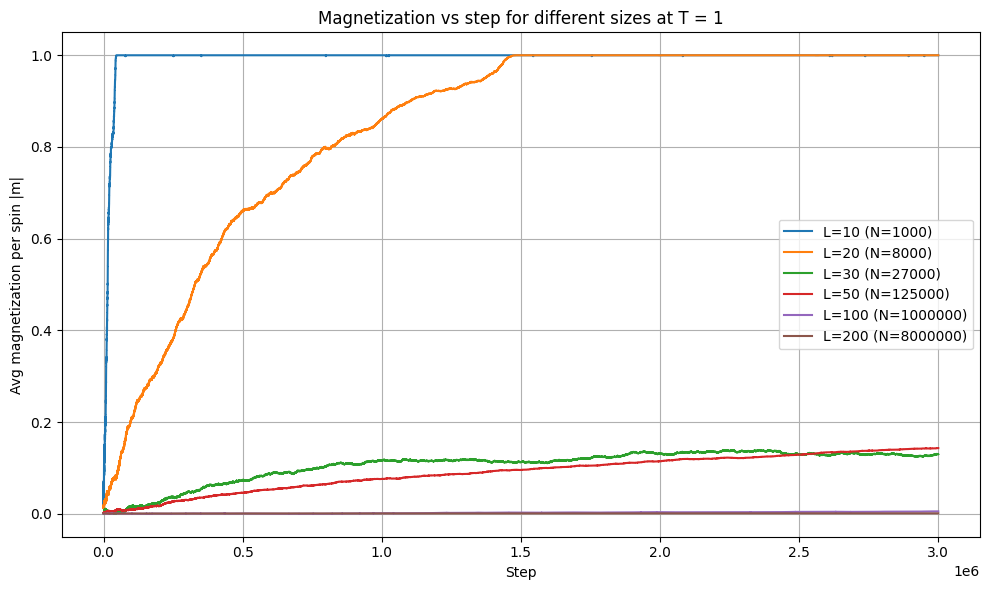

In [47]:
J = 1.0
nstep = 3000000
seed = 67
T = 1       

sizes = [10, 20, 30, 50, 100, 200]

plt.figure(figsize=(10, 6))

for L in sizes:
    state = 2 * np.random.randint(2, size=(L, L, L)) - 1
    e_hist, m_hist, final_state = run_simulation_fast(state, L, T, J, nstep, seed)
    plt.plot(np.abs(m_hist), label=f"L={L} (N={L**3})")

plt.xlabel("Step")
plt.ylabel("Avg magnetization per spin |m|")
plt.title(f"Magnetization vs step for different sizes at T = {T}")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

The equilibrium
state at this temperature is fully ordered, with magnetization |m| ≈ 1.
However, we observe that only the smallest systems approach this value within the
simulation time eventhough we set the number of steps to be 3000000. This behaviour is expected. The number of spin–flip attempts scales linearly with
the total number of steps, whereas the system size scales as L³. As L increases,
a fixed number of Monte Carlo steps corresponds to far fewer sweeps, meaning
each spin is updated extremely rarely. 

This slow convergence is a result of critical slowing down, even far
below the critical temperature, because domain coarsening in the Metropolis
algorithm proceeds only through local updates. Close to the critical temperature the system would take even way more time to converge. To handle this issue, more efficient cluster algorithms exist, such as the
Wolff algorithm, which flips entire correlated spin clusters at once and
dramatically accelerates equilibration.

## Wolff cluster update

The standard single–spin Metropolis update becomes very inefficient near the critical temperature $T_c$. Large domains of aligned spins form, and flipping a single spin inside such a domain usually costs a large positive $\Delta E$, so the Metropolis acceptance
$$
A(x \to x') = \min\left(1, e^{-\beta \Delta E}\right), \quad \beta = \frac{1}{T},
$$
is tiny. The result is **critical slowing down**: configurations change very slowly and autocorrelation times blow up.

The **Wolff algorithm** fixes this by flipping entire **clusters of aligned spins** in one move. For the 3D Ising model (same Hamiltonian as above, just with 6 nearest neighbours), one Wolff update is:

1. **Seed selection**  
   Pick a random lattice site $i_0$ and set $s_0 = s_{i_0}$.  
   Initialize the cluster
   $$
   C = \{ i_0 \}.
   $$

2. **Cluster growth**  
   For each site $i \in C$ consider each of its 6 nearest neighbours $j$:
   - If $s_j = s_0$ (parallel spin), add $j$ to the cluster with probability
     $$
     P_{\text{add}} = 1 - e^{-2 \beta}.
     $$
   - Newly added sites are treated in the same way.  
   - Repeat until no new spins are added.

3. **Cluster flip**  
   Flip all spins in the cluster:
   $$
   s_i \to -s_i \quad \forall\, i \in C.
   $$

This single cluster flip replaces many single–spin flips and acts as a **non-local move** in configuration space. At high $T$, $P_{\text{add}}$ is small and clusters stay small; near $T_c$ clusters grow large and entire domains can flip at once.

The specific choice
$$
P_{\text{add}} = 1 - e^{-2 \beta}
$$
is made so that the **construction probability of a given cluster** already carries the correct Boltzmann weighting. The proposal probabilities satisfy
$$
q(x \to x') = Q (1 - P_{\text{add}})^m, \qquad
q(x' \to x) = Q (1 - P_{\text{add}})^n,
$$
and with $E(x') - E(x) = 2(m - n)$ this choice of $P_{\text{add}}$ makes
$$
\frac{A(x \to x')}{A(x' \to x)} = 1.
$$
So we can set $A(x \to x') = A(x' \to x) = 1$: **every Wolff cluster move is accepted**, and detailed balance with respect to the Boltzmann distribution is enforced purely by the cluster growth rule.


In [ ]:
def wolff_step(state, T, J):
    """
    Perform ONE Wolff cluster flip.
    Returns:
        cluster_size, deltaE
    where deltaE is the energy change due to the cluster flip.
    """
    L = state.shape[0]
    beta = 1.0 / T
    p_add = 1.0 - exp(-2.0 * beta * J)

    i0 = np.random.randint(0, L)
    j0 = np.random.randint(0, L)
    k0 = np.random.randint(0, L)
    spin0 = state[i0, j0, k0]

    visited = np.zeros_like(state, dtype=bool)
    stack = [(i0, j0, k0)]
    visited[i0, j0, k0] = True
    cluster = []

    while stack:
        i, j, k = stack.pop()
        cluster.append((i, j, k))

        neighbours = (
            ((i + 1) % L, j, k), ((i - 1) % L, j, k),
            (i, (j + 1) % L, k), (i, (j - 1) % L, k),
            (i, j, (k + 1) % L), (i, j, (k - 1) % L),
        )

        for ni, nj, nk in neighbours:
            if visited[ni, nj, nk]:
                continue

            if state[ni, nj, nk] == spin0:
                if np.random.random() < p_add:
                    visited[ni, nj, nk] = True
                    stack.append((ni, nj, nk))

    deltaE = 0.0
    for (i, j, k) in cluster:
        s = state[i, j, k]
        neighbours = (
            ((i + 1) % L, j, k), ((i - 1) % L, j, k),
            (i, (j + 1) % L, k), (i, (j - 1) % L, k),
            (i, j, (k + 1) % L), (i, j, (k - 1) % L),
        )
        for ni, nj, nk in neighbours:
            if not visited[ni, nj, nk]:
                deltaE += 2.0 * J * s * state[ni, nj, nk]

    for (i, j, k) in cluster:
        state[i, j, k] = -state[i, j, k]

    return len(cluster), deltaE

### Number of steps vs number of sweeps

In our simulations, **one Monte Carlo step** in the Metropolis algorithm means **one attempted single–spin flip**.

For a cubic lattice with side length $L$, the total number of spins is
$$
N = L^3.
$$

A natural time unit is a **sweep**, defined as
$$
1\ \text{sweep} \approx N \ \text{single–spin update attempts}.
$$

In the case $L = 10$ we used
$$
N = 10^3 = 1000, \qquad n_{\text{steps}} = 50\,000,
$$
which corresponds to
$$
n_{\text{sweeps}} \approx \frac{n_{\text{steps}}}{N}
= \frac{50\,000}{1000} = 50 \ \text{sweeps}.
$$

If we kept the **same number of steps** when increasing $L$, the number of sweeps would scale like
$$
n_{\text{sweeps}} = \frac{n_{\text{steps}}}{L^3},
$$
so for large lattices (e.g. $L = 100$) we would perform **far less than one sweep** and the system would barely evolve.

To make simulations for different lattice sizes comparable, we therefore fix the **number of sweeps** (here: $n_{\text{sweeps}} = 50$) and adjust the total number of spin updates accordingly:
$$
n_{\text{updates}} = n_{\text{sweeps}} \times L^3.
$$

- For **Metropolis**, this means running until we have attempted $n_{\text{updates}}$ single–spin flips.
- For **Wolff**, one cluster flip updates $\text{cluster\_size}$ spins, so we accumulate $\text{cluster\_size}$ in a counter until the same total number of spin updates $n_{\text{updates}}$ is reached.

This way, all simulations (different $L$, different algorithms) correspond to roughly the same physical simulation time measured in sweeps.


In [200]:

def run_dynamics(state, J, T, nsweep, algo="metropolis"):
    """
    Run nstep Monte Carlo steps with either Metropolis or Wolff.
    """
    L = state.shape[0]

    e_old = energy(state, J)

    e_history = []
    m_history = []
    total_steps = 0
    nstep = nsweep * (L**3)
    while total_steps < nstep:

        if algo == "metropolis":
            i = np.random.randint(L)
            j = np.random.randint(L)
            k = np.random.randint(L)

            dE = delta_energy(state, i, j, k, J)
            e_new = e_old + dE
            total_steps += 1

            if metropolis(e_old, e_new, T):
                flip(state, i, j, k)
                e_old = e_new

        elif algo == "wolff":
            cluster_size, dE = wolff_step(state, T, J)
            e_old += dE
            total_steps += cluster_size
            #print(total_steps)
            
        else:
            raise ValueError("algo must be 'metropolis' or 'wolff'")

        e_history.append(e_old)
        m_history.append(magnetization(state))

    return e_history, m_history

## Magnetization vs temperature, for different values of the number of spins N = $L^3$

### Practical note on running the simulations

Because the simulations for larger lattices become very time–consuming
(particularly near the critical region and for $L=50,70,100$), we split the
computation into two stages:

- one run for the **smaller lattices** ($L=10,15,20,25,30$),
- a separate run for the **larger lattices** ($L=50,70,100$).

After each stage we immediately save the measured magnetization data to CSV
files (`mag_vs_T.csv` and `mag_vs_T_big_L.csv`). This way, if a long run is
interrupted or the notebook crashes, we can reload the results from disk and
reproduce the final plots without rerunning all simulations.


In [ ]:
L_list = [10, 15,20,25,30]
T_list = np.arange(2.0, 6.1, 0.25)
J = 1.0
nsweeps = 50
seed = 42

mag_vs_T = {L: [] for L in L_list}

for L in L_list:
    for T in T_list:
        tot = time.time()
        print("Run: L = {}, T = {}".format(L,T))

        np.random.seed(seed)
        state = 2 * np.random.randint(2, size=(L, L, L)) - 1

        e_hist, m_hist = run_dynamics(state, J, T, nsweeps, algo="wolff")

        cut = len(m_hist) // 3
        m_sel = np.array(m_hist[cut:])

        mag_vs_T[L].append(np.mean(np.abs(m_sel)))  # ⟨|m|⟩
        print("Time taken: {} seconds".format(round(time.time()-tot, 2)))


In [ ]:
rows = []
for L in mag_vs_T:
    mags = mag_vs_T[L]
    for T, m in zip(T_list, mags):
        rows.append({"L": L, "T": T, "mag_abs": m})

df = pd.DataFrame(rows)
df.to_csv("mag_vs_T.csv", index=False)

print("Saved to mag_vs_T.csv")

Saved to mag_vs_T.csv


In [ ]:
L_list = [50,70,100]
T_list = np.arange(2.0, 6.1, 0.25)
J = 1.0
nsweeps = 50
seed = 42

mag_vs_T_big_L = {L: [] for L in L_list}

for L in L_list:
    for T in T_list:
        tot = time.time()
        print("Run: L = {}, T = {}".format(L,T))

        np.random.seed(seed)
        state = 2 * np.random.randint(2, size=(L, L, L)) - 1

        e_hist, m_hist = run_dynamics(state, J, T, nsweeps, algo="wolff")

        cut = len(m_hist) // 3
        m_sel = np.array(m_hist[cut:])

        mag_vs_T_big_L[L].append(np.mean(np.abs(m_sel)))  # ⟨|m|⟩
        print("Time taken: {} seconds".format(round(time.time()-tot, 2)))

In [ ]:
rows = []
for L in mag_vs_T_big_L:      
    mags = mag_vs_T_big_L[L]
    for T, m in zip(T_list, mags):
        rows.append({"L": L, "T": T, "mag_abs": m})

df = pd.DataFrame(rows)
df.to_csv("mag_vs_T_big_L.csv", index=False)

print("Saved to mag_vs_T_big_L.csv")

Saved to mag_vs_T_big_L.csv


Once we have all the values we need, we extract them from the .csv files and combine them, then proceed to plot the values.

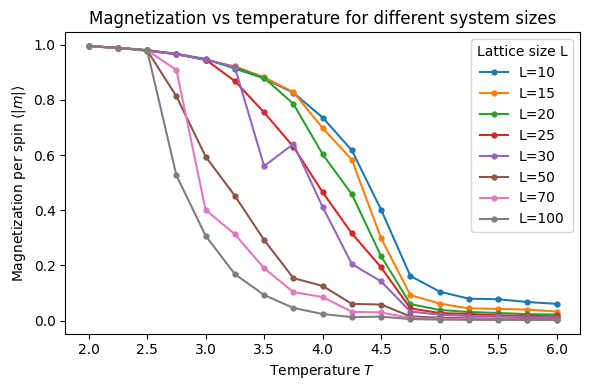

In [ ]:
df_small = pd.read_csv("mag_vs_T.csv")
df_big   = pd.read_csv("mag_vs_T_big_L.csv")

df_all = pd.concat([df_small, df_big], ignore_index=True)

plt.figure(figsize=(6, 4))

for L, df_L in df_all.groupby("L"):
    df_L_sorted = df_L.sort_values("T")
    plt.plot(
        df_L_sorted["T"],
        df_L_sorted["mag_abs"],
        marker="o",
        markersize=3.5,
        label=f"L={int(L)}"
    )

plt.xlabel("Temperature $T$")
plt.ylabel("Magnetization per spin $\\langle |m| \\rangle$")
plt.title("Magnetization vs temperature for different system sizes")
plt.legend(title="Lattice size L")
plt.tight_layout()
plt.show()


## Evaluation of results

The plot above shows the temperature dependence of the magnetization per spin
$\langle |m| \rangle$ for several lattice sizes $L$.

**Qualitative behaviour**

- For all $L$, the system is **ordered at low temperature**:
  $\langle |m| \rangle \approx 1$ around $T = 2$.
- For all $L$, the system becomes **disordered at high temperature**:
  $\langle |m| \rangle \to 0$ for $T \gtrsim 5$.
- In between, there is a **crossover region** where the magnetization drops
  rapidly, corresponding to the ferromagnetic–paramagnetic transition.

**Finite–size effects**

- The transition is **broad and smooth** for small lattices (e.g. $L=10$),
  and becomes **progressively sharper** as $L$ increases.  
  This is the expected finite–size rounding of a second–order phase
  transition: in the thermodynamic limit $L \to \infty$ the drop in
  $\langle |m| \rangle$ would become discontinuous at $T_c$.
- Near the crossover region (roughly $T \sim 3.5$–$4.5$ in these data),
  curves for different $L$ are clearly separated: at the same $T$, larger
  lattices tend to have **smaller** $\langle |m| \rangle$. This is
  consistent with the approach to a true phase transition in the
  infinite–volume limit.

**Limitations**

- For the largest lattices ($L=70$ and $L=100$) the magnetization already
  starts to decrease around $T \approx 2.5$–$3.0$, whereas the true critical
  temperature of the 3D Ising model is $T_c \approx 4.5$.  
  This indicates **insufficient equilibration** for those sizes (only
  50 Wolff sweeps from a random initial state), so the curves for large $L$
  are shifted towards lower temperatures.
- In principle, larger lattices would require **more sweeps** to reach good
  equilibrium near $T_c$. In practice we deliberately kept the number of
  sweeps fixed at 50 for all $L$ to keep the total runtime manageable:
  the separate “runtime vs temperature” plot shows that the cost per run
  grows very rapidly with both $L$ and $T$. Increasing the sweep count for
  $L=70$ and $L=100$ would make those runs prohibitively expensive.
- Therefore, this figure should be interpreted qualitatively: it clearly
  demonstrates the sharpening of the transition and the increasing
  $L$–dependence of $\langle |m| \rangle(T)$, but it is **not** a precise
  determination of $T_c$ for the largest lattices.


We now import the values for the time taken for each simulation run

In [ ]:
rows = []
with open("times.txt") as f:
    lines = [line.strip() for line in f if line.strip()]

for i in range(0, len(lines), 2):
    run_line  = lines[i]
    time_line = lines[i+1]

    m_run  = re.search(r"L\s*=\s*(\d+),\s*T\s*=\s*([0-9.]+)", run_line)
    m_time = re.search(r"Time taken:\s*([0-9.]+)", time_line)

    L   = int(m_run.group(1))
    T   = float(m_run.group(2))
    t_s = float(m_time.group(1))

    rows.append({"L": L, "T": T, "time_s": t_s})

df_time = pd.DataFrame(rows)
print(df_time.head())


    L     T  time_s
0  10  2.00    0.50
1  10  2.25    0.36
2  10  2.50    0.34
3  10  2.75    0.38
4  10  3.00    0.38


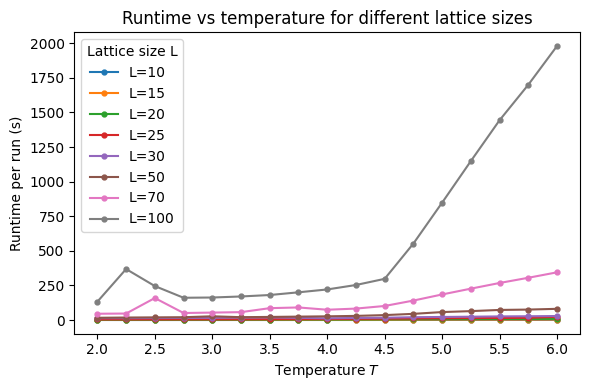

In [223]:
plt.figure(figsize=(6, 4))

for L, dfL in df_time.groupby("L"):
    dfL = dfL.sort_values("T")
    plt.plot(dfL["T"], dfL["time_s"], marker="o", markersize=3.5, label=f"L={L}")

plt.xlabel("Temperature $T$")
plt.ylabel("Runtime per run (s)")
plt.title("Runtime vs temperature for different lattice sizes")
plt.legend(title="Lattice size L")
plt.tight_layout()
plt.show()


## Runtime vs temperature for different lattice sizes

The runtime plot shows that the cost of a simulation grows very rapidly with
both lattice size $L$ and temperature $T$:

- For small lattices ($L=10$–$30$) each run is sub–second to a few seconds.
- For larger lattices ($L=70$ and especially $L=100$) the runtime per
  temperature point increases to hundreds or even thousands of seconds.

This behaviour reflects the $O(L^3)$ scaling of the algorithm (we repeatedly
touch all $N=L^3$ spins) combined with the properties of the Wolff update:
at higher $T$ the clusters become smaller, so many more cluster updates are
needed to reach the same number of sweeps. The steep growth of the runtime
with $L$ and $T$ is the main reason we kept the number of sweeps fixed at 50
for all system sizes in the magnetization study.


## Conclusions and next steps

#### Setup recap

We simulated the 3D Ising model with the Metropolis single–spin update (1 step = 1 attempted flip) and later defined a sweep as ~L³ attempted flips to control for the fact that one single Wolff step could be flipping potentially hundreds of thousands of spins. Critical slowing appears even well below Tc, so fixed-step runs under-sample large lattices.

#### Transition behavior

- Magnetization vs temperature shows the expected ferromagnetic → paramagnetic crossover.  
- The drop sharpens with larger L, consistent with approaching the thermodynamic transition.  
- Finite-size rounding is evident for small lattices; larger L produces a steeper decline.

#### Limitations

We deliberately kept the setup simple (fixed 50 Wolff sweeps at
each $(L, T)$, pure Python implementation). This is enough to see the basic
physics and finite–size effects, but it is not optimal for very large lattices and led to some clear issues:
- For L = 70, 100 the magnetization drops too early (T ~ 2.5–3 vs true Tc ~ 4.5) a sign of under-equilibration because only 50 sweeps were used.  
- Single–spin Metropolis is very slow near Tc; even with Wolff, the largest lattices need more updates to equilibrate.

#### Impact of Wolff updates  
- The Wolff cluster move mitigates critical slowing (non-local flips of correlated domains) and makes the larger-L exploration feasible, but the fixed 50-sweep budget still limits equilibration for the biggest systems.


#### Improvements for future exploration

- **Better equilibration strategies**
  - Use *simulated annealing*: start from high $T$, gradually cool down, and
    reuse the final configuration at one temperature as the initial condition
    for the next. This reduces the number of sweeps needed to reach
    equilibrium at each $T$.
  - Use *parallel tempering* :
    simulate multiple copies of the system at different temperatures and
    occasionally swap configurations. This helps the system cross free–energy
    barriers and equilibrate much faster near $T_c$.

- **More efficient use of simulation time**
  - Instead of a fixed 50 sweeps for all $(L, T)$, adapt the number of sweeps
    to an estimate of the autocorrelation time, or at least spend more sweeps
    near the critical region and fewer far away from it.
  - Use techniques like *histogram reweighting*: from a single simulation near
    a given $T$, reconstruct observables at nearby temperatures, reducing the
    total number of separate runs needed.

- **Algorithmic and implementation improvements**
  - Move the inner loops of the Wolff update (cluster growth and energy
    updates) to compiled code (Numba, Cython, C/C++). This avoids Python
    overhead and makes each sweep much cheaper.
  - Reuse auxiliary arrays (e.g. the `visited` array) instead of reallocating
    them for every cluster, to reduce memory traffic.
  - For very large lattices, a GPU or multi–core implementation (e.g. via
    CUDA/OpenCL or JAX) could exploit massive parallelism in spin updates and
    neighbour checks.


Overall, the results presented here capture the correct qualitative behaviour
of the 3D Ising model and illustrate finite–size effects, but there is plenty
of room to improve computational efficiency and accuracy with more advanced
Monte Carlo techniques and more optimised implementations.

